# **Projeto de Classificação de Animais - Etapa 1**

## **1. Instalação das bibliotecas necessárias**

In [23]:
# Instalação de pacotes necessários

!pip install opendatasets
!pip install pandas
!pip install imagehash

## **2. Baixando o conjunto de dados do [Kaggle](https://www.kaggle.com/datasets/anthonytherrien/image-classification-64-classes-animal)**

In [24]:
# Baixando o conjunto de dados

import opendatasets as od

od.download("https://www.kaggle.com/datasets/anthonytherrien/image-classification-64-classes-animal")

Skipping, found downloaded files in "./image-classification-64-classes-animal" (use force=True to force download)


In [25]:
# Processamento e Análise de Dados

!ls

image-classification-64-classes-animal	sample_data


## **3. Criar um Dataframe com os metadados das imagens**

In [26]:
# Importação de bibliotecas para processamento de imagens, manipulação de dados e visualização

import cv2
import os
import imagehash
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

In [27]:
# Listas para armazenar dados sobre imagens corrompidas e dados processados

corrupted = []
df_list = []

# Diretório raiz das imagens para classificação de animais

root_dir = '/content/image-classification-64-classes-animal/image/'

In [28]:
# Função para processar imagens e extrair informações

def process_image(image_path, animal):
    if not os.path.isfile(image_path):
        return [image_path, True, None, None, None, None, None, animal]

    img = cv2.imread(image_path)
    if img is None:
        return [image_path, True, None, None, None, None, None, animal]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    img_hash = imagehash.phash(img_pil)
    width, height, channels = img.shape
    image_format = os.path.splitext(image_path)[-1]

    return [image_path, False, img_hash, image_format, width, height, channels, animal]

In [29]:
# Função para processar todas as imagens de um diretório específico de animais

def process_animal(animal_dir, animal):
    image_paths = [os.path.join(animal_dir, image) for image in os.listdir(animal_dir) if os.path.isfile(os.path.join(animal_dir, image))]

    with ProcessPoolExecutor() as executor:
        results = executor.map(process_image, image_paths, [animal] * len(image_paths))

    valid_results = []
    for result in results:
        if result:
            if result[1]:
                corrupted.append(result[0])
            valid_results.append(result)
    return valid_results

In [30]:
# Processamento Paralelo de Diretórios de Imagens de Animais

for animal in os.listdir(root_dir):
    animal_dir = os.path.join(root_dir, animal)
    if os.path.isdir(animal_dir):
        results = process_animal(animal_dir, animal)
        df_list.extend(results)

In [31]:
# Relatório de Imagens Corrompidas no Dataset

print(f'Total de Imagens Corrompidas: {len(corrupted)}\n'
      f'Imagens corrompidas:\n{corrupted}')

Total de Imagens Corrompidas: 0
Imagens corrompidas:
[]


In [32]:
# Criação de DataFrame com os resultados do processamento de imagens

df = pd.DataFrame(columns=['image_path', 'corrupted', 'image_hash', 'image_format', 'width', 'height', 'channels', 'label'], data = df_list)
df.head()

,image_path,corrupted,image_hash,image_format,width,height,channels,label
0,/content/image-classification-64-classes-anima...,False,9da56a9a802d9da7,.png,512,512,3,duck
1,/content/image-classification-64-classes-anima...,False,f40c4a3f9bc43e07,.png,512,512,3,duck
2,/content/image-classification-64-classes-anima...,False,f641443c9af8cf92,.png,512,512,3,duck
3,/content/image-classification-64-classes-anima...,False,966a69c9b04ec3b5,.png,512,512,3,duck
4,/content/image-classification-64-classes-anima...,False,96764dc91b63e494,.png,512,512,3,duck


## **4. Verificação da Integridade dos arquivos**

In [33]:
# Estatísticas Descritivas das Imagens Processadas

df.describe().loc[['mean', 'std', 'min', 'max']]

,width,height,channels
mean,512.0,512.0,3.0
std,0.0,0.0,0.0
min,512.0,512.0,3.0
max,512.0,512.0,3.0


(array([0]), [Text(0, 0, '.png')])

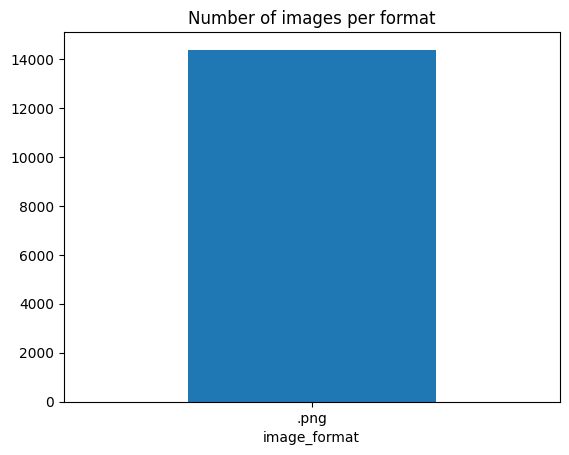

In [34]:
# Distribuição de Imagens por Formato

df['image_format'].value_counts().plot(kind='bar', title='Number of images per format')
plt.xticks(rotation=0)

## **5. Verificação da Consistência dos Metadados**

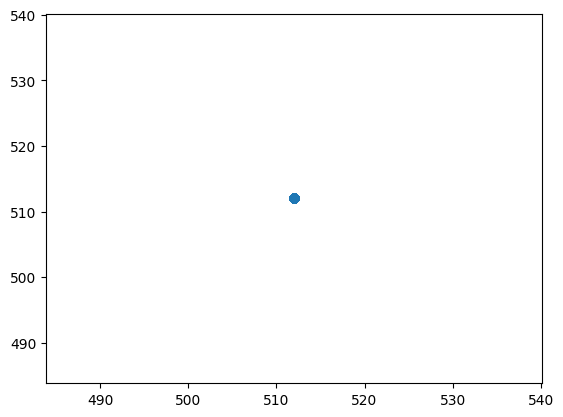

In [35]:
# Verificando se há valores discrepantes em termos de dimensão das imagens, utilizando o data frame criado

plt.scatter(df['width'], df['height'])

In [36]:
# Verificando se há campos nulos no data frame

df.isnull().sum()

,0
image_path,0
corrupted,0
image_hash,0
image_format,0
width,0
height,0
channels,0
label,0


## **6. Analisando a Qualidade das Imagens**

In [37]:
# Contagem Total de Imagens Corrompidas

df['corrupted'].sum()

0

In [38]:
# Distribuição de Imagens Corrompidas e Não Corrompidas

df['corrupted'].value_counts()

,count
corrupted,
False,14377


## **7. Verificação da Distribuição de Classes**

label
dog         456
cat         432
frog        312
elephant    288
beaver      216
           ... 
deer        216
giraffe     216
squid       215
jaguar      186
mole        176
Name: count, Length: 64, dtype: int64


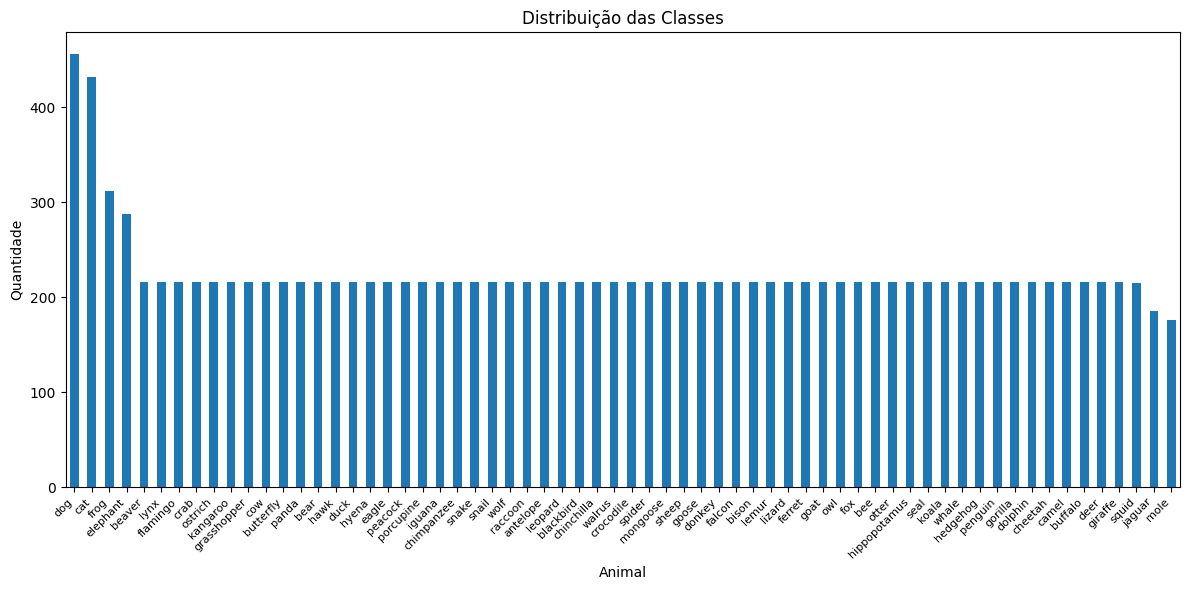

In [39]:
# Distribuição das Classes de Animais no Dataset

class_distribution = df['label'].value_counts()
print(class_distribution)

class_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Distribuição das Classes')
plt.xlabel('Animal')
plt.ylabel('Quantidade')

plt.xticks(rotation=45, ha='right', fontsize=8)  #Rotacionar os rótulos e ajustar o tamanho da fonte

plt.tight_layout()  #Ajustar o layout para evitar sobreposição de rótulos
plt.show()

In [ ]:
# Exibição de Imagens de Teste para Cada Rótulo de Classe

unique_labels = df['label'].unique()

#Itera por cada rótulo único
for label in unique_labels:
    #Filtra o dataframe para o rótulo atual
    subset = df[df['label'] == label]

    #Seleciona os caminhos das duas primeiras imagens(Usando as duas primeiras imagens como teste)
    image_paths = subset['image_path'].head(2).tolist()

    # Cria uma figura e eixos para as imagens
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, image_path in enumerate(image_paths):
        img = plt.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **8. Verificando a Presença de Duplicatas**

In [41]:
# Quantidade de imagens duplicatas

df['image_hash'].duplicated().sum()

0